# Pylops - Least squares image-domain migration - marmousi model

### Author: M.Ravasi

In this notebook we show how to use the ``NonStationaryConvolve2D`` operator to perform image-domain least-squares migration

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from numba import jit

from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.avo.poststack              import PoststackLinearModelling, PoststackInversion

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *

## Model and data creation

Lets' create a model and geometry

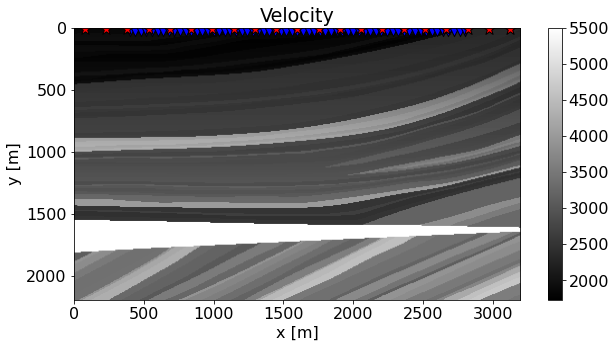

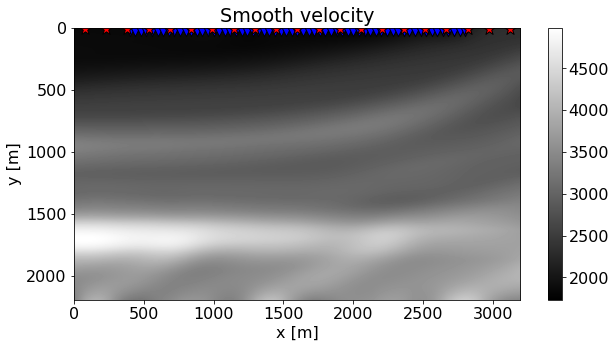

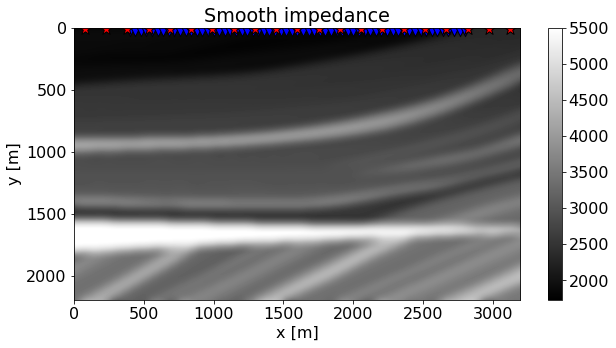

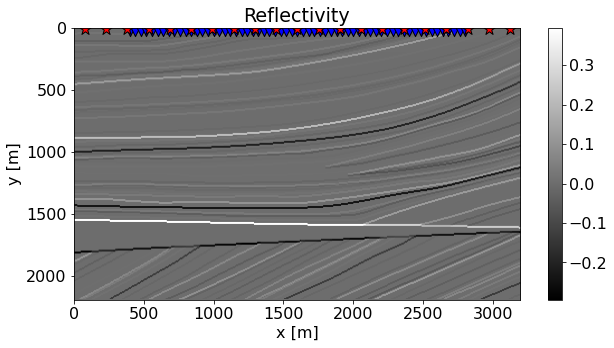

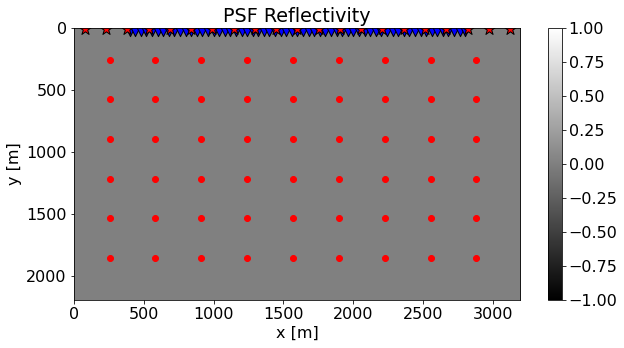

In [2]:
#Velocity
inputfile='../../pylops/testdata/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, vel_true = model['x'] - model['x'][0], model['z'] - model['z'][0], 1000*model['model'].T
x, z, vel_true = x[::2], z[::2], vel_true[::2, ::2]
nx, nz = len(x), len(z)
dx, dz = x[1]-x[0], z[1]-z[0]

# Impedance
rho = 1.
ip_true = rho * vel_true

# Reflectivity
Dop = FirstDerivative(dims=(nx, nz), axis=1)
refl = Dop * np.log(ip_true)

# PSF Model
psfrefl = np.zeros((nx, nz))
psfrefl = np.zeros((nx, nz))
psfin = (32, 32)
psfend = (-32, -32)
psfj = (41, 40)
psfsize = (31, 31)
psfrefl[psfin[0]:psfend[0]:psfj[0], psfin[1]:psfend[-1]:psfj[-1]] = 1

# PSF grid
psfx = np.arange(psfin[0], nx+psfend[0], psfj[0])
psfz = np.arange(psfin[1], nz+psfend[1], psfj[1])
Psfx, Psfz = np.meshgrid(psfx, psfz, indexing='ij')

# Smooth velocity
nsmooth = 30
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_sm, axis=1)

# Smooth impedance
nsmooth = 10
ip_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, ip_true, axis=0)
ip_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, ip_sm, axis=1)

# Receivers
nr = 61
rx = np.linspace(dx*50, (nx-50)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 21
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel_sm.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(ip_sm.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth impedance')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(psfrefl.T, cmap='gray', vmin=-1, vmax=1, extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(Psfx.ravel()*dx, Psfz.ravel()*dz, c='r')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('PSF Reflectivity')
plt.xlim(x[0], x[-1]);

### Dataset creation and migration

In [3]:
nt = 601
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

kop = Kirchhoff(z, x, t, sources, recs, vel_sm, wav, wavc, mode='eikonal', 
                dynamic=False, wavfilter=True, engine='numba')
kopdyn = Kirchhoff(z, x, t, sources, recs, vel_sm, wav, wavc, mode='eikonal', 
                   dynamic=True, wavfilter=True, aperture=2, angleaperture=50, engine='numba')

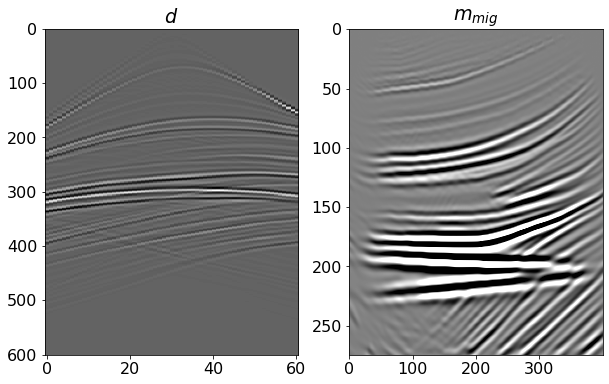

In [4]:
d = kop * refl.ravel()
d = d.reshape(ns, nr, nt)

mmig = kopdyn.H * d.ravel()
mmig = mmig.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(d[ns//2, :, :].T, cmap='gray', interpolation='none')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(mmig.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{mig}$')
axs[1].axis('tight');

### PSF creation and migration

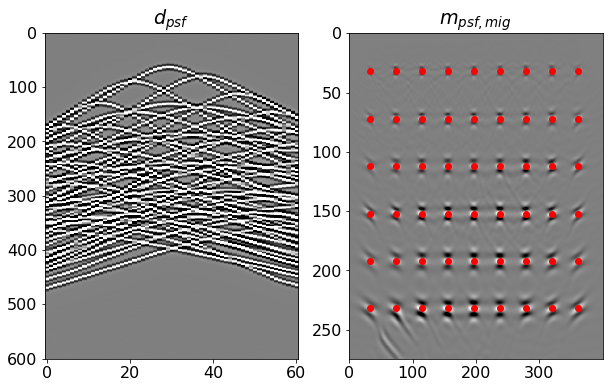

In [5]:
dpsf = kop * psfrefl.ravel()
dpsf = dpsf.reshape(ns, nr, nt)

mmigpsf = kopdyn.H * dpsf.ravel()
mmigpsf = mmigpsf.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(dpsf[ns//2, :, :].T, cmap='gray', vmin=-1e2, vmax=1e2, interpolation='none')
axs[0].set_title(r'$d_{psf}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf.T, cmap='gray', vmin=-4, vmax=4)
axs[1].scatter(Psfx.ravel(), Psfz.ravel(), c='r')
axs[1].set_title(r'$m_{psf,mig}$')
axs[1].axis('tight');

## Image domain LSM

First, we extract the different PSFs

In [6]:
psfs = np.zeros((len(psfx), len(psfz), *psfsize))

for ipx, px in enumerate(psfx):
    for ipz, pz in enumerate(psfz):
        psfs[ipx, ipz] = mmigpsf[int(px-psfsize[0]//2):int(px+psfsize[0]//2+1), 
                                 int(pz-psfsize[1]//2):int(pz+psfsize[1]//2+1)] 

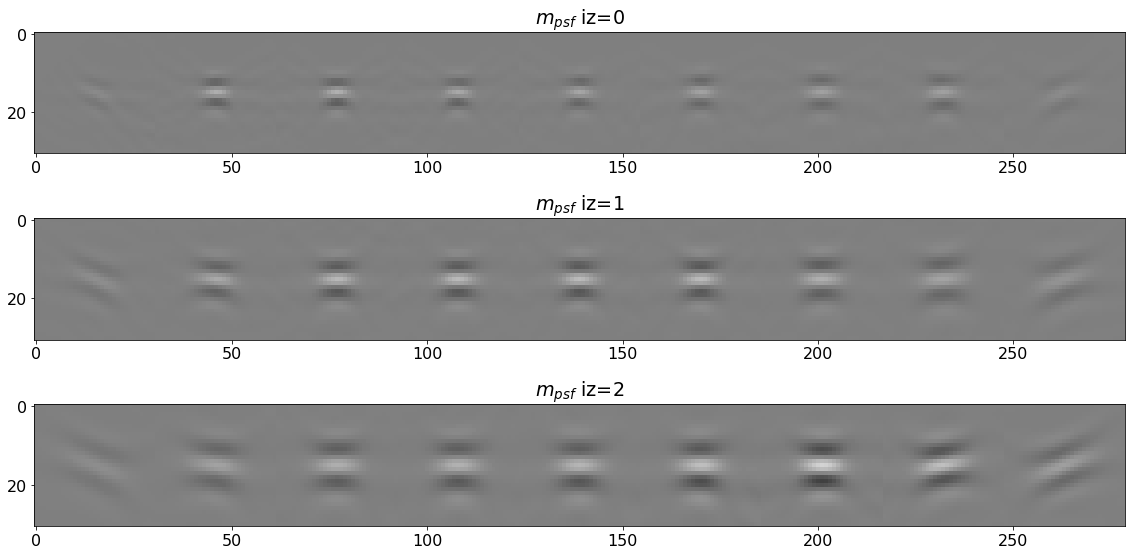

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(16, 8))
axs[0].imshow(psfs[:, 0].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[0].set_title(r'$m_{psf}$ iz=0')
axs[0].axis('tight')
axs[1].imshow(psfs[:, 1].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{psf}$ iz=1')
axs[1].axis('tight')
axs[2].imshow(psfs[:, 2].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[2].set_title(r'$m_{psf}$ iz=2')
axs[2].axis('tight')
plt.tight_layout()

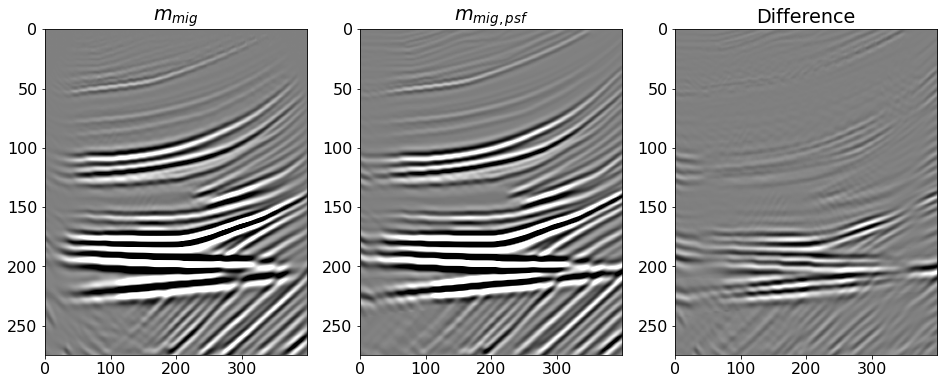

In [8]:
Cop = NonStationaryConvolve2D(hs=psfs, ihx=psfx, ihz=psfz, dims=(nx, nz), engine="numba")

mmigpsf = Cop * refl.ravel()
mmigpsf = mmigpsf.reshape(nx, nz)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-mmigpsf.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[2].set_title(r'Difference')
axs[2].axis('tight');

In [9]:
dottest(Cop, verb=True, raiseerror=False);

Dot test passed, v^H(Opu)=3249.887105266791 - u^H(Op^Hv)=3249.887105266783


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 110000 rows and 110000 cols
eps = 4.000000e+01	tol = 1.000000e-10	niter = 200
alpha = 1.776704e-06	thresh = 3.553409e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         2.047e+06   2.058e+06   2.148e+00
     2       0.0000e+00         1.275e+06   1.295e+06   1.282e+00
     3       0.0000e+00         8.253e+05   8.513e+05   1.111e+00
     4       0.0000e+00         5.685e+05   6.006e+05   9.368e-01
     5       0.0000e+00         4.152e+05   4.524e+05   7.952e-01
     6       0.0000e+00         3.166e+05   3.582e+05   6.898e-01
     7       0.0000e+00         2.484e+05   2.939e+05   6.124e-01
     8       0.0000e+00         1.988e+05   2.476e+05   5.539e-01
     9       0.0000e+00         1.615e+05   2.132e+05   5.069e-01
    10      

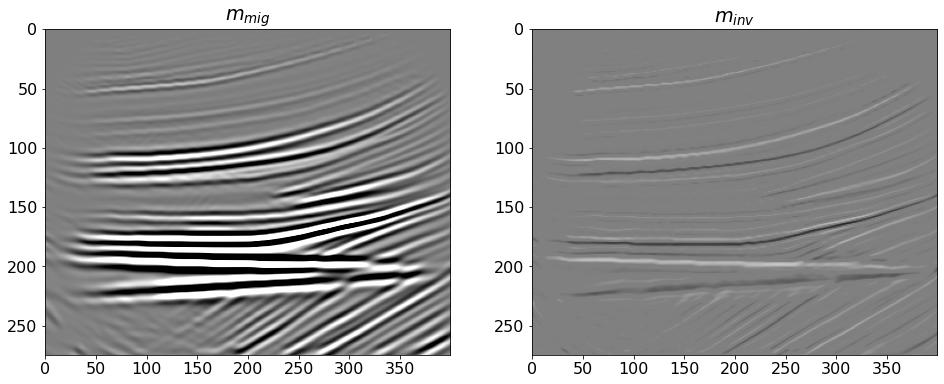

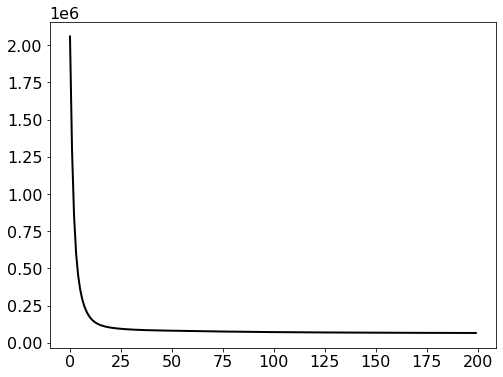

In [10]:
reflinv, _, resnorm = fista(Cop, mmig.ravel(), eps=4e1, niter=200, 
                            eigsdict=dict(niter=5, tol=1e-2), show=True)
reflinv = reflinv.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(reflinv.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].set_title(r'$m_{inv}$')
axs[1].axis('tight')

plt.figure()
plt.plot(resnorm, 'k', lw=2);

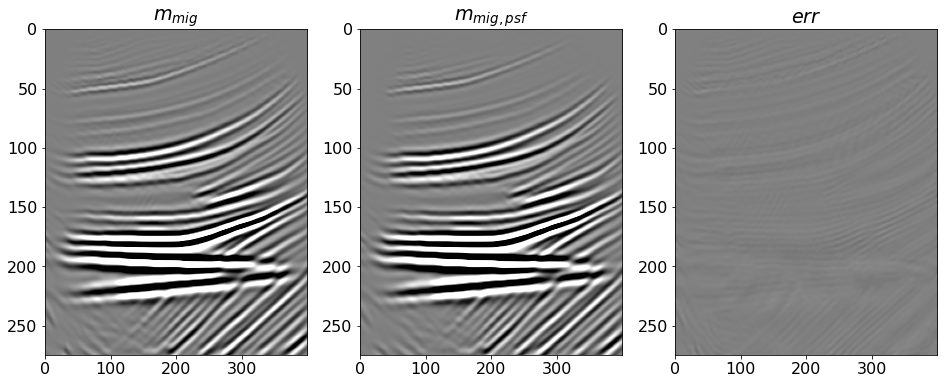

In [11]:
dinv = Cop @ reflinv.ravel()
dinv = dinv.reshape(nx, nz)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(dinv.T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-dinv.T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$err$')
axs[2].axis('tight');

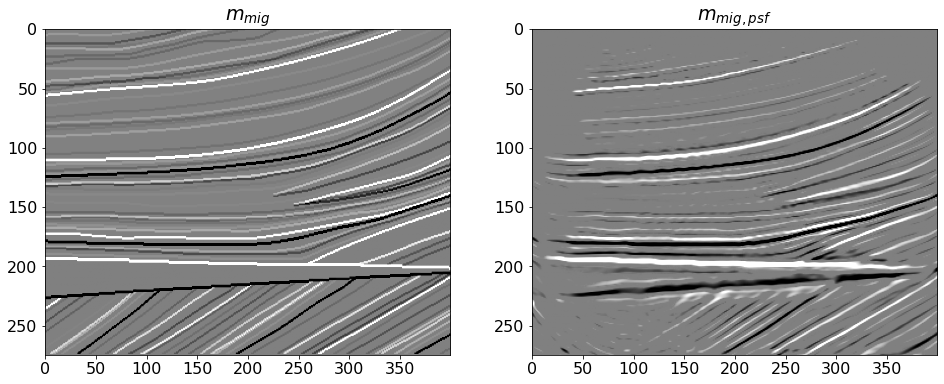

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(refl.T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(reflinv.T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight');

## Image domain LSM for impedance

### Post-stack 1D inversion

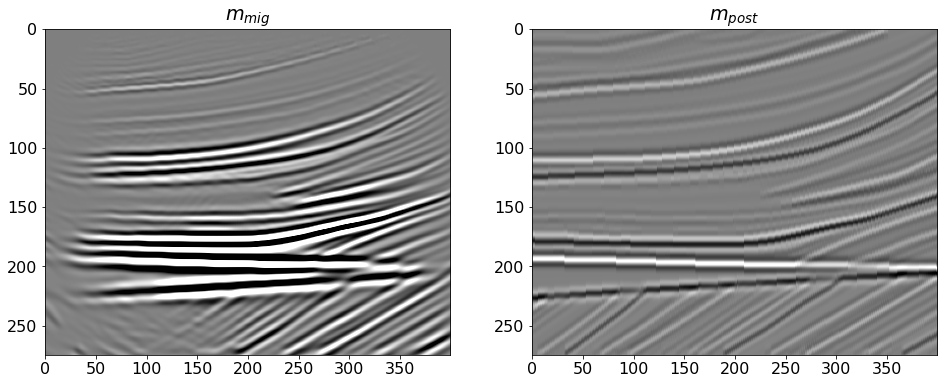

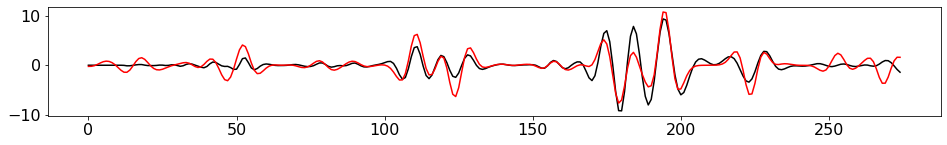

In [13]:
# Poststack 1d operator
Cop_post = PoststackLinearModelling(wav * 15, nt0=nz, spatdims=nx)

# data
mpost = Cop_post * np.log(ip_true).T

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(mpost, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{post}$')
axs[1].axis('tight')

plt.figure(figsize=(16, 2))
plt.plot(mmig[40], 'k')
plt.plot(mpost[:, 40], 'r');

In [14]:
# L2 regularized inversion
Lop = Laplacian(dims=(nz, nx), dtype=Cop_post.dtype)
ip_post = regularized_inversion(Cop_post, mpost.ravel(), [Lop], 
                                x0=np.log(ip_sm).T.ravel(), epsRs=[1e-1],
                                **dict(iter_lim=100, damp=1e-4))[0]
ip_post = np.exp(ip_post).reshape(nz, nx)

# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 5e-2
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Cop_post, b=mpost.ravel(), niter=10, warm=True, sigma=0.001)
Gop = Gradient(dims=(nz, nx), edge=True, dtype=Cop_post.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

ip_post_pd = PrimalDual(l2, l1, Gop, np.log(ip_sm).T.ravel(), tau=tau, mu=mu, gfirst=True,
                        theta=1., niter=20, show=True)
ip_post_pd = np.exp(ip_post_pd).reshape(nz, nx)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.vstack.VStack'>
Additional vector (z): None
tau = 1.0		mu = 0.12375
theta = 1.00		niter = 20

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.52702e+00   4.736e+01   8.616e+01   0.000e+00       1.335e+02
     2   7.52833e+00   1.831e+01   1.047e+02   0.000e+00       1.230e+02
     3   7.52860e+00   1.155e+01   1.107e+02   0.000e+00       1.222e+02
     4   7.52838e+00   9.757e+00   1.109e+02   0.000e+00       1.206e+02
     5   7.52793e+00   9.426e+00   1.082e+02   0.000e+00       1.177e+02
     6   7.52746e+00   9.596e+00   1.043e+02   0.000e+00       1.139e+02
     7   7.52713e+00   9.904e+00   1.011e+02   0.000e+00       1.110e+02
     8   7.52705e+00   1.019e+01   9.961e+01   0.0

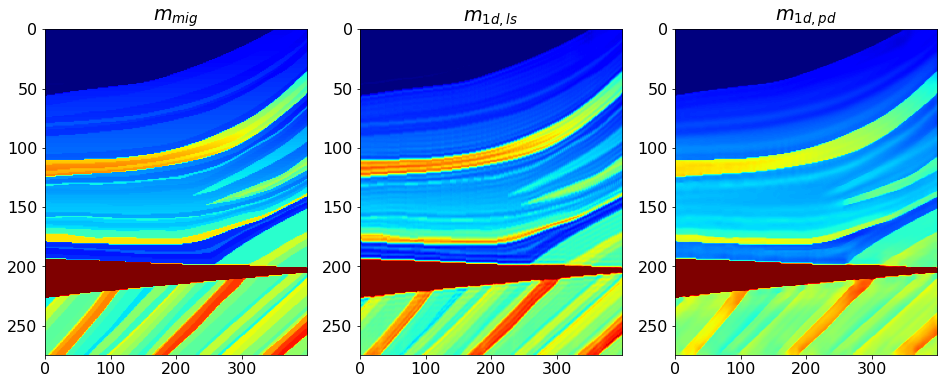

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(ip_true.T, cmap='jet', vmin=2000, vmax=5000)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(ip_post, cmap='jet', vmin=2000, vmax=5000)
axs[1].set_title(r'$m_{1d,ls}$')
axs[1].axis('tight')
axs[2].imshow(ip_post_pd, cmap='jet', vmin=2000, vmax=5000)
axs[2].set_title(r'$m_{1d,pd}$')
axs[2].axis('tight');

Finally, we try to invert the migrated image and see how the quality degrades.

In [16]:
# L2 regularized inversion
Lop = Laplacian(dims=(nz, nx), dtype=Cop_post.dtype)
ip_post = regularized_inversion(Cop_post, mmig.T.ravel(), [Lop], 
                                x0=np.log(ip_sm).T.ravel(), epsRs=[1e-1],
                                **dict(iter_lim=100, damp=1e-4))[0]
ip_post = np.exp(ip_post).reshape(nz, nx)

# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 5e-2
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Cop_post, b=mmig.T.ravel(), niter=10, warm=True, sigma=0.001)
Gop = Gradient(dims=(nz, nx), edge=True, dtype=Cop_post.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

ip_post_pd = PrimalDual(l2, l1, Gop, np.log(ip_sm).T.ravel(), tau=tau, mu=mu, gfirst=True,
                        theta=1., niter=20, show=True)
ip_post_pd = np.exp(ip_post_pd).reshape(nz, nx)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.vstack.VStack'>
Additional vector (z): None
tau = 1.0		mu = 0.12375
theta = 1.00		niter = 20

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.52493e+00   8.308e+02   2.349e+02   0.000e+00       1.066e+03
     2   7.52721e+00   2.550e+02   3.184e+02   0.000e+00       5.734e+02
     3   7.52955e+00   1.189e+02   3.464e+02   0.000e+00       4.652e+02
     4   7.53176e+00   7.562e+01   3.516e+02   0.000e+00       4.272e+02
     5   7.53368e+00   5.803e+01   3.504e+02   0.000e+00       4.084e+02
     6   7.53525e+00   4.963e+01   3.492e+02   0.000e+00       3.989e+02
     7   7.53649e+00   4.515e+01   3.484e+02   0.000e+00       3.936e+02
     8   7.53747e+00   4.251e+01   3.473e+02   0.0

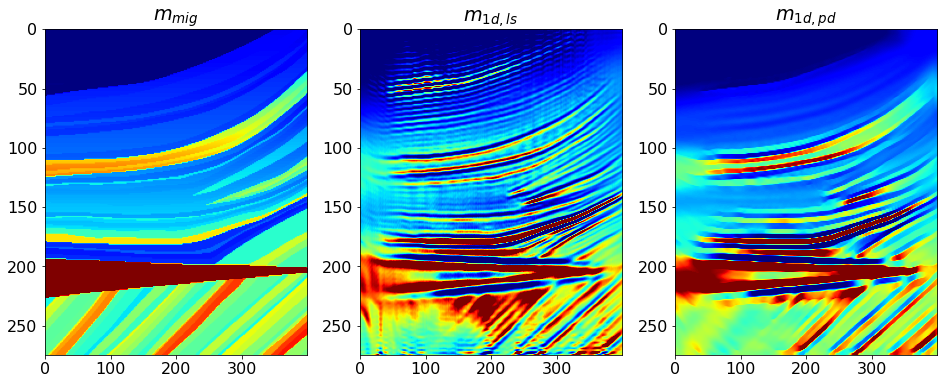

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(ip_true.T, cmap='jet', vmin=2000, vmax=5000)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(ip_post, cmap='jet', vmin=2000, vmax=5000)
axs[1].set_title(r'$m_{1d,ls}$')
axs[1].axis('tight')
axs[2].imshow(ip_post_pd, cmap='jet', vmin=2000, vmax=5000)
axs[2].set_title(r'$m_{1d,pd}$')
axs[2].axis('tight');

### Post-stack 2D stationary inversion (inverse crime)

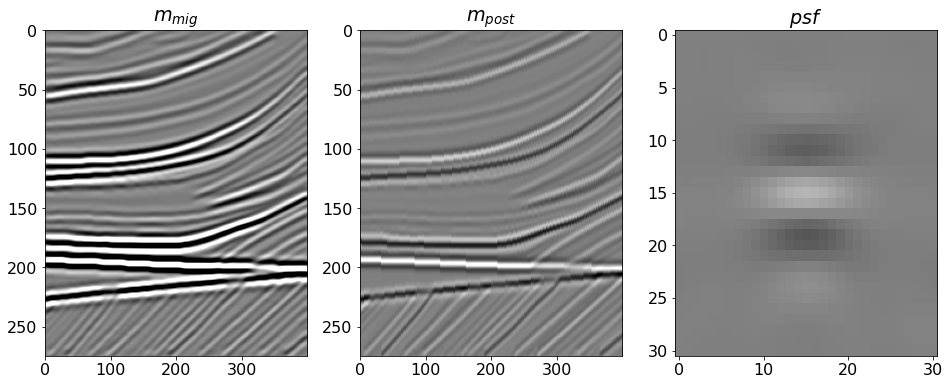

In [18]:
# Poststack 2d stationary operator
psfs_stat = np.zeros_like(psfs)
for ix in range(len(psfx)):
    for iz in range(len(psfz)):
        psfs_stat[ix, iz] = psfs[4, 2]

Cop_stat = Convolve2D(dims=(nx, nz), h=psfs[4, 2], offset=(psfsize[0]//2, psfsize[1]//2))
#Cop_stat = NonStationaryConvolve2D(psfs_stat, psfx, psfz, dims=(nx, nz), engine="numba")

mmigpsf_stat = Cop_stat * refl

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmigpsf_stat.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(mpost, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{post}$')
axs[1].axis('tight')
axs[2].imshow(psfs[4, 2].T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$psf$')
axs[2].axis('tight');

In [19]:
# L2 regularized inversion
Lop = Laplacian(dims=(nx, nz), dtype=Lop.dtype)
ip_stat_inv = regularized_inversion(Cop_stat * Dop, mmigpsf_stat.ravel(), [Lop], 
                                    x0=np.log(ip_sm).ravel(), epsRs=[1e-1], show=True,
                                    **dict(iter_lim=100, damp=1e-4))[0]
ip_stat_inv = np.exp(ip_stat_inv).reshape(nx, nz)

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 110000 rows and 110000 cols
Regs=[<110000x110000 LinearOperator with dtype=float64>]
epsRs=[0.1]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 220000 rows and 110000 columns
damp = 1.00000000000000e-04   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.029e+03  2.029e+03    1.0e+00  7.0e-02
     1  2.72625e-03   7.514e+02  7.514e+02    3.7e-01  6.2e-01   1.5e+02  1.0e+00
     2  4.96366e-03   4.508e+02  4.508e+02    2.2e-01  3.8e-01   2.0e+02  2.1e+00
     3  6.25730e-03   3.219e+02  3.219e+02    1.6e-01  2.8e-01   2.3e+02  3.5e+00
     4  6.66301e-03   2.489e+02  2.489e+02    1.2e-01  2.2e-01   2.6e+02  5.0e+00
     5

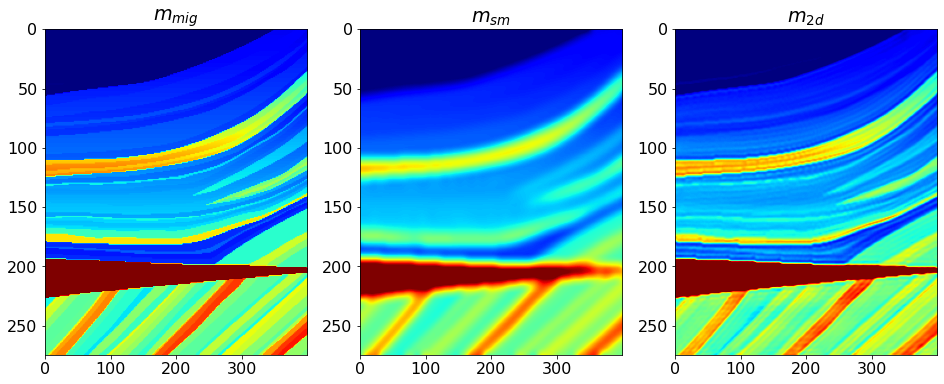

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(ip_true.T, cmap='jet', vmin=2000, vmax=5000)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(ip_sm.T, cmap='jet', vmin=2000, vmax=5000)
axs[1].set_title(r'$m_{sm}$')
axs[1].axis('tight')
axs[2].imshow(ip_stat_inv.T, cmap='jet', vmin=2000, vmax=5000)
axs[2].set_title(r'$m_{2d}$')
axs[2].axis('tight');

In [21]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 1e-2
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Cop_stat * Dop, b=mmigpsf_stat.ravel(), niter=10, warm=True, sigma=0.0001)
Gop = Gradient(dims=(nx, nz), edge=True, dtype=Cop_stat.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

ip_stat_pd = PrimalDual(l2, l1, Gop, np.log(ip_sm).ravel(), tau=tau, mu=mu, gfirst=True,
                        theta=1., niter=100, show=True)
ip_stat_pd = np.exp(ip_stat_pd).reshape(nx, nz)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.vstack.VStack'>
Additional vector (z): None
tau = 1.0		mu = 0.12375
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.52641e+00   3.219e+01   1.620e+01   0.000e+00       4.839e+01
     2   7.52885e+00   1.078e+01   1.904e+01   0.000e+00       2.983e+01
     3   7.53068e+00   6.058e+00   1.987e+01   0.000e+00       2.593e+01
     4   7.53191e+00   4.331e+00   1.989e+01   0.000e+00       2.422e+01
     5   7.53255e+00   3.496e+00   1.971e+01   0.000e+00       2.321e+01
     6   7.53270e+00   3.028e+00   1.960e+01   0.000e+00       2.262e+01
     7   7.53252e+00   2.740e+00   1.953e+01   0.000e+00       2.227e+01
     8   7.53220e+00   2.548e+00   1.950e+01   0.

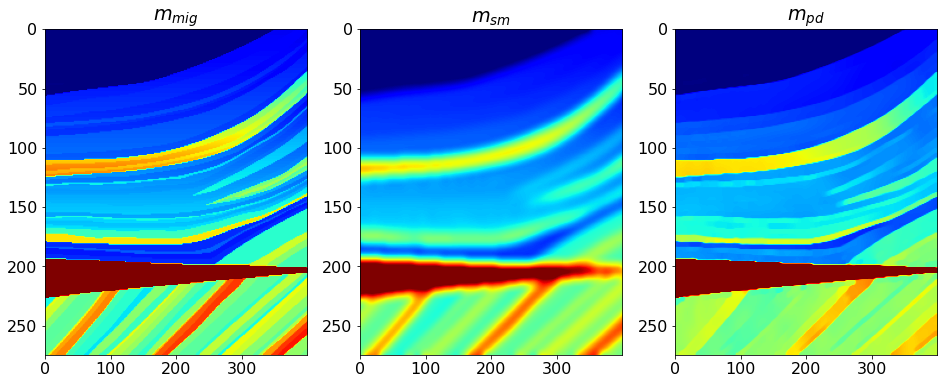

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(ip_true.T, cmap='jet', vmin=2000, vmax=5000)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(ip_sm.T, cmap='jet', vmin=2000, vmax=5000)
axs[1].set_title(r'$m_{sm}$')
axs[1].axis('tight')
axs[2].imshow(ip_stat_pd.T, cmap='jet', vmin=2000, vmax=5000)
axs[2].set_title(r'$m_{pd}$')
axs[2].axis('tight');

### Post-stack 2D non-stationary inversion (inverse crime)

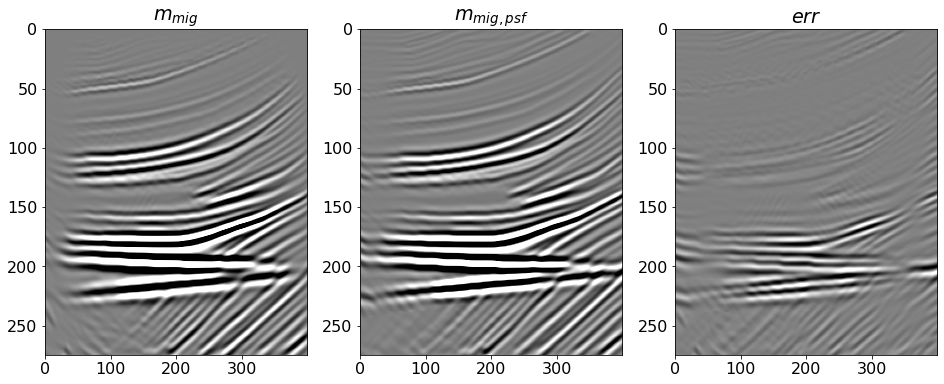

In [23]:
# Impedance LSM operator
LSMop = Cop * Dop
mmigpsf = LSMop * np.log(ip_true)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf.T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-mmigpsf.T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$err$')
axs[2].axis('tight');

In [24]:
# Regularized inversion
Regop = Laplacian(dims=(nx, nz))
ip_inv = regularized_inversion(LSMop, mmigpsf.ravel(), [Regop], 
                                x0=np.log(ip_sm).ravel(),
                                epsRs=[1e-10], **dict(iter_lim=200, show=True))[0]
ip_inv = np.exp(ip_inv).reshape(nx, nz)

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 110000 rows and 110000 cols
Regs=[<110000x110000 LinearOperator with dtype=float64>]
epsRs=[1e-10]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 220000 rows and 110000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.744e+03  2.744e+03    1.0e+00  8.8e-02
     1  4.25500e-06   1.274e+03  1.274e+03    4.6e-01  6.5e-01   2.7e+02  1.0e+00
     2  9.96611e-06   8.904e+02  8.904e+02    3.2e-01  4.2e-01   3.8e+02  2.1e+00
     3  1.70753e-05   6.934e+02  6.934e+02    2.5e-01  2.9e-01   4.8e+02  3.5e+00
     4  2.62747e-05   5.608e+02  5.608e+02    2.0e-01  2.3e-01   5.7e+02  5.2e+00
    

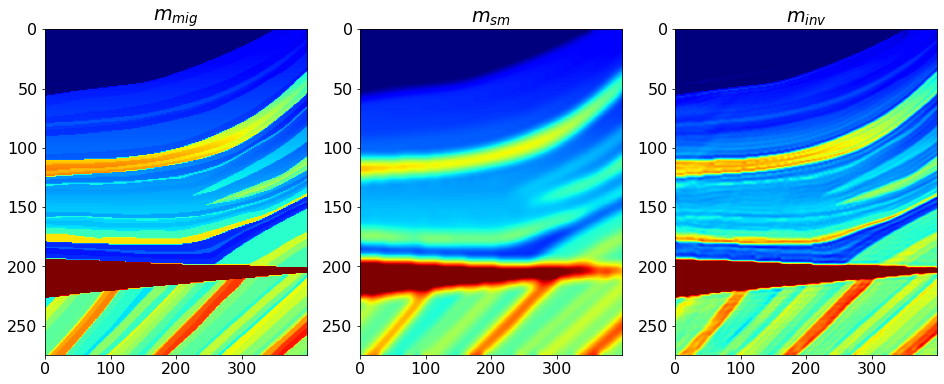

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(ip_true.T, cmap='jet', vmin=2000, vmax=5000)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(ip_sm.T, cmap='jet', vmin=2000, vmax=5000)
axs[1].set_title(r'$m_{sm}$')
axs[1].axis('tight')
axs[2].imshow(ip_inv.T, cmap='jet', vmin=2000, vmax=5000)
axs[2].set_title(r'$m_{inv}$')
axs[2].axis('tight');

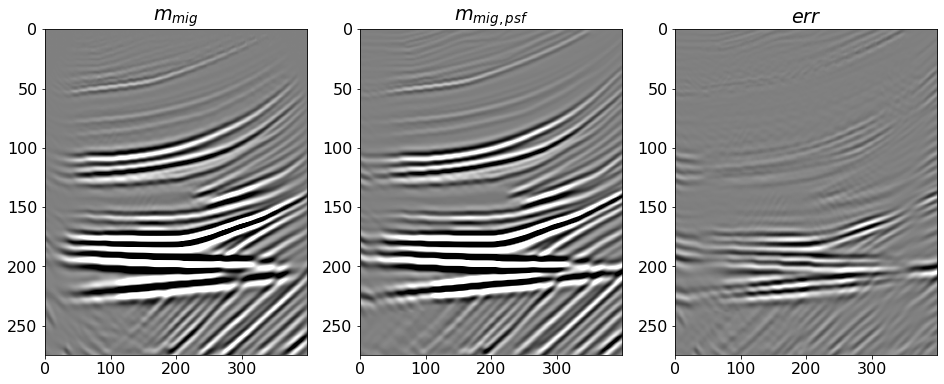

In [26]:
minv = LSMop @ np.log(ip_inv)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(minv.T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-minv.T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$err$')
axs[2].axis('tight');

In [27]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
Gop = Gradient(dims=(nx, nz), edge=True, dtype=LSMop.dtype, kind='forward')

sigma=1e-3
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=LSMop, b=mmigpsf.ravel(), x0=np.log(ip_sm).ravel(), niter=10, warm=True, sigma=0.0001)

# steps
L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

ip_admm = LinearizedADMM(l2, l1, Gop, tau=tau, mu=mu, x0=np.log(ip_sm).ravel(), niter=100, show=True)[0]
ip_admm = np.exp(ip_admm).reshape(nx,nz)

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.vstack.VStack'>
tau = 1.000000e+00	mu = 1.237500e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   7.52349e+00   1.495e+02   1.331e+00   1.508e+02
     2   7.52374e+00   7.500e+01   1.452e+00   7.645e+01
     3   7.52387e+00   4.597e+01   1.553e+00   4.752e+01
     4   7.52400e+00   3.238e+01   1.630e+00   3.401e+01
     5   7.52412e+00   2.490e+01   1.689e+00   2.659e+01
     6   7.52425e+00   2.023e+01   1.736e+00   2.196e+01
     7   7.52438e+00   1.703e+01   1.775e+00   1.881e+01
     8   7.52451e+00   1.471e+01   1.808e+00   1.651e+01
     9   7.52464e+00   1.294e+01   1.835e+00   1.477e+01
    10   7.52476e+00   1.154e+01   1.860e+00   1.340e+01
    11   7.52489e+00   1.041e+01   1.881e+00   1.229e+01
    2

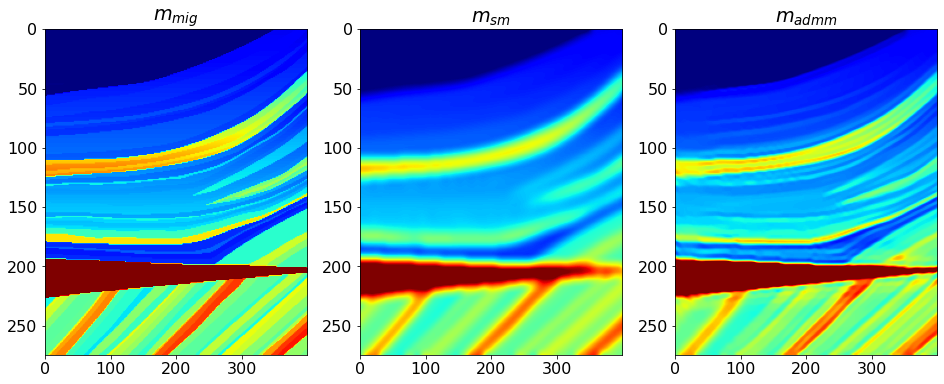

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(ip_true.T, cmap='jet', vmin=2000, vmax=5000)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(ip_sm.T, cmap='jet', vmin=2000, vmax=5000)
axs[1].set_title(r'$m_{sm}$')
axs[1].axis('tight')
axs[2].imshow(ip_admm.T, cmap='jet', vmin=2000, vmax=5000)
axs[2].set_title(r'$m_{admm}$')
axs[2].axis('tight');

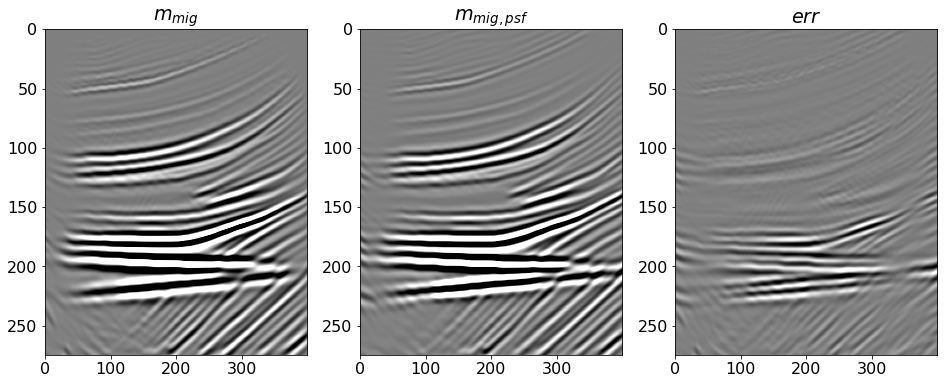

In [29]:
madmm = LSMop @ np.log(ip_admm)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(madmm.T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-madmm.T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$err$')
axs[2].axis('tight');

In [30]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 1e-3
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=LSMop, b=mmigpsf.ravel(), x0=np.log(ip_sm).ravel(), niter=10, warm=True, sigma=0.0001)
Gop = Gradient(dims=(nx, nz), edge=True, dtype=LSMop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

ip_pd = PrimalDual(l2, l1, Gop, np.log(ip_sm).ravel(), tau=tau, mu=mu, 
                    theta=1., niter=100, show=True)
ip_pd = np.exp(ip_pd).reshape(nx,nz)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.vstack.VStack'>
Additional vector (z): None
tau = 1.0		mu = 0.12375
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.52305e+00   3.526e+01   1.656e+00   0.000e+00       3.691e+01
     2   7.52334e+00   1.583e+01   1.864e+00   0.000e+00       1.769e+01
     3   7.52375e+00   9.772e+00   1.969e+00   0.000e+00       1.174e+01
     4   7.52426e+00   6.721e+00   2.037e+00   0.000e+00       8.759e+00
     5   7.52485e+00   4.932e+00   2.086e+00   0.000e+00       7.018e+00
     6   7.52552e+00   3.791e+00   2.119e+00   0.000e+00       5.910e+00
     7   7.52622e+00   3.029e+00   2.142e+00   0.000e+00       5.171e+00
     8   7.52698e+00   2.496e+00   2.156e+00   0.

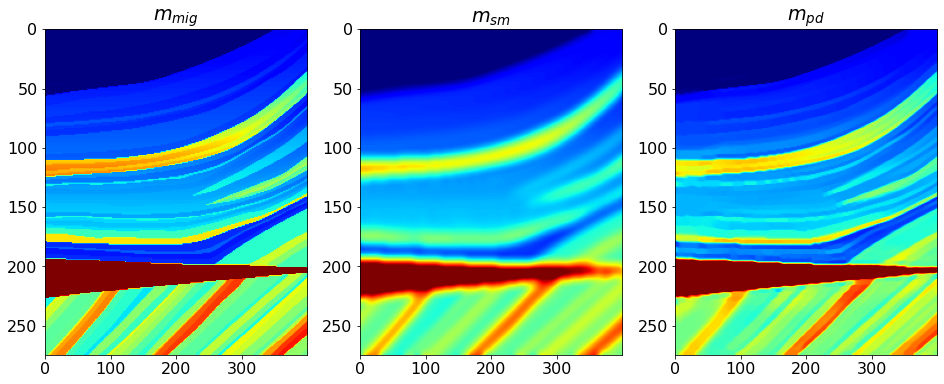

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(ip_true.T, cmap='jet', vmin=2000, vmax=5000)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(ip_sm.T, cmap='jet', vmin=2000, vmax=5000)
axs[1].set_title(r'$m_{sm}$')
axs[1].axis('tight')
axs[2].imshow(ip_pd.T, cmap='jet', vmin=2000, vmax=5000)
axs[2].set_title(r'$m_{pd}$')
axs[2].axis('tight');

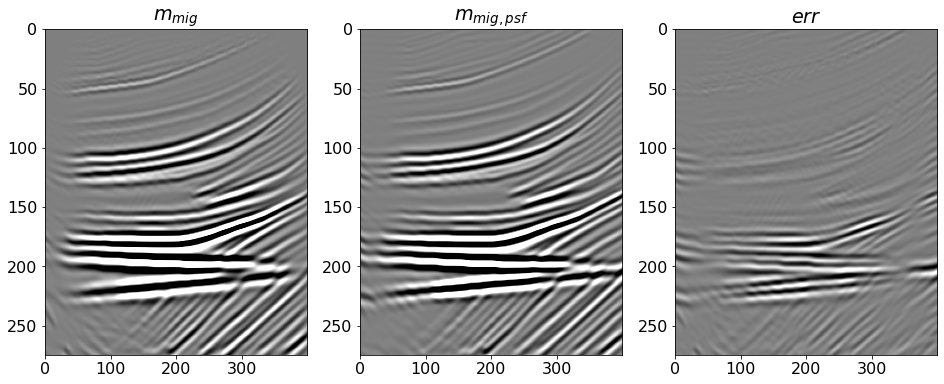

In [32]:
mpd = LSMop @ np.log(ip_pd)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(mpd.T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-mpd.T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$err$')
axs[2].axis('tight');

### Post-stack 2D stationary inversion (with Kirchhoff migration data)

In [33]:
# Regularized inversion
Regop = Laplacian(dims=(nx, nz))
ip_inv = regularized_inversion(LSMop, mmig.ravel(), [Regop], 
                                x0=np.log(ip_sm).ravel(),
                                epsRs=[1e1], **dict(iter_lim=50, show=True))[0]
ip_inv = np.exp(ip_inv).reshape(nx, nz)

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 110000 rows and 110000 cols
Regs=[<110000x110000 LinearOperator with dtype=float64>]
epsRs=[10.0]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 220000 rows and 110000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.775e+03  2.775e+03    1.0e+00  8.6e-02
     1  1.94882e-06   1.282e+03  1.282e+03    4.6e-01  6.4e-01   2.7e+02  1.0e+00
     2  4.65586e-06   8.887e+02  8.887e+02    3.2e-01  4.2e-01   3.7e+02  2.1e+00
     3  7.92229e-06   6.885e+02  6.885e+02    2.5e-01  3.1e-01   4.7e+02  3.5e+00
     4  1.19332e-05   5.558e+02  5.558e+02    2.0e-01  2.3e-01   5.6e+02  5.2e+00
     

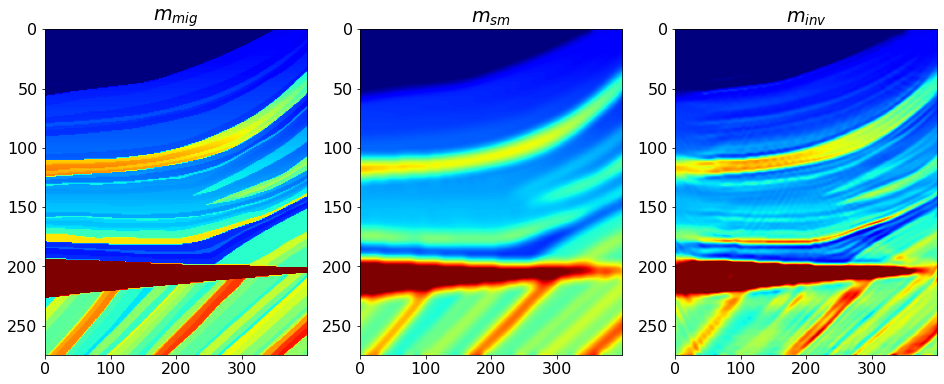

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(ip_true.T, cmap='jet', vmin=2000, vmax=5000)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(ip_sm.T, cmap='jet', vmin=2000, vmax=5000)
axs[1].set_title(r'$m_{sm}$')
axs[1].axis('tight')
axs[2].imshow(ip_inv.T, cmap='jet', vmin=2000, vmax=5000)
axs[2].set_title(r'$m_{inv}$')
axs[2].axis('tight');

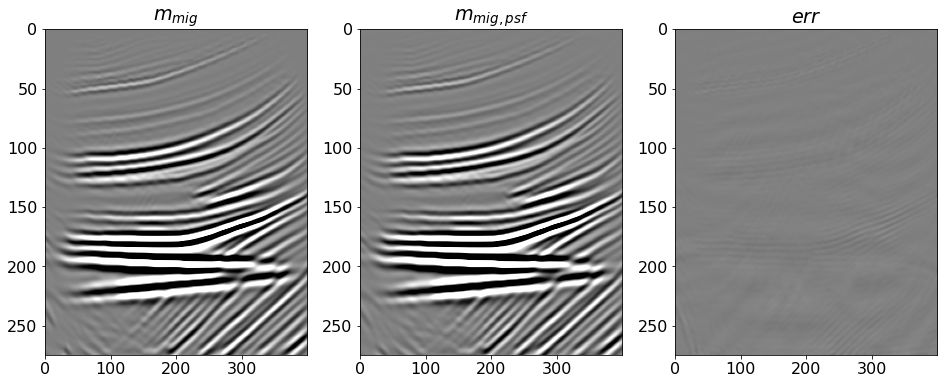

In [35]:
minv = LSMop @ np.log(ip_inv)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(minv.T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-minv.T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$err$')
axs[2].axis('tight');

In [36]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 1e-1 # 1e-2
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=LSMop, b=mmig.ravel(), x0=np.log(ip_sm).ravel(), niter=10, warm=True, sigma=0.001)
Gop = Gradient(dims=(nx, nz), edge=True, dtype=LSMop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

ip_pd = PrimalDual(l2, l1, Gop, np.log(ip_sm).ravel(), tau=tau, mu=mu, 
                    theta=1., niter=100, show=True)
ip_pd = np.exp(ip_pd).reshape(nx,nz)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.vstack.VStack'>
Additional vector (z): None
tau = 1.0		mu = 0.12375
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.52294e+00   3.231e+02   1.811e+02   0.000e+00       5.041e+02
     2   7.52295e+00   1.630e+02   1.996e+02   0.000e+00       3.626e+02
     3   7.52296e+00   1.150e+02   2.024e+02   0.000e+00       3.174e+02
     4   7.52298e+00   9.395e+01   2.083e+02   0.000e+00       3.023e+02
     5   7.52300e+00   8.037e+01   2.093e+02   0.000e+00       2.897e+02
     6   7.52303e+00   7.050e+01   2.127e+02   0.000e+00       2.832e+02
     7   7.52306e+00   6.399e+01   2.131e+02   0.000e+00       2.771e+02
     8   7.52310e+00   5.769e+01   2.152e+02   0.

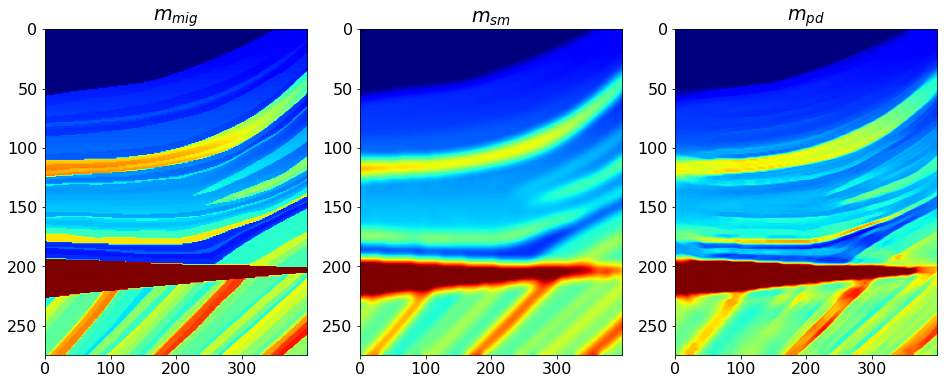

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(ip_true.T, cmap='jet', vmin=2000, vmax=5000)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(ip_sm.T, cmap='jet', vmin=2000, vmax=5000)
axs[1].set_title(r'$m_{sm}$')
axs[1].axis('tight')
axs[2].imshow(ip_pd.T, cmap='jet', vmin=2000, vmax=5000)
axs[2].set_title(r'$m_{pd}$')
axs[2].axis('tight');

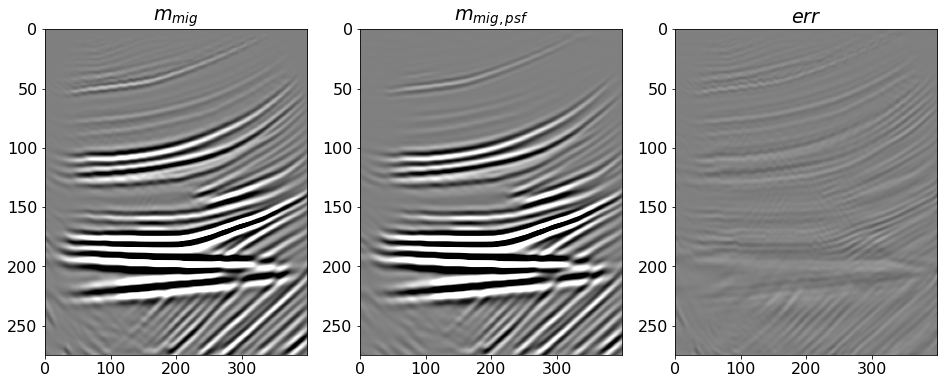

In [38]:
mpd = LSMop @ np.log(ip_pd)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(mpd.T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-mpd.T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$err$')
axs[2].axis('tight');

## PSF checking with stationary convolution

True

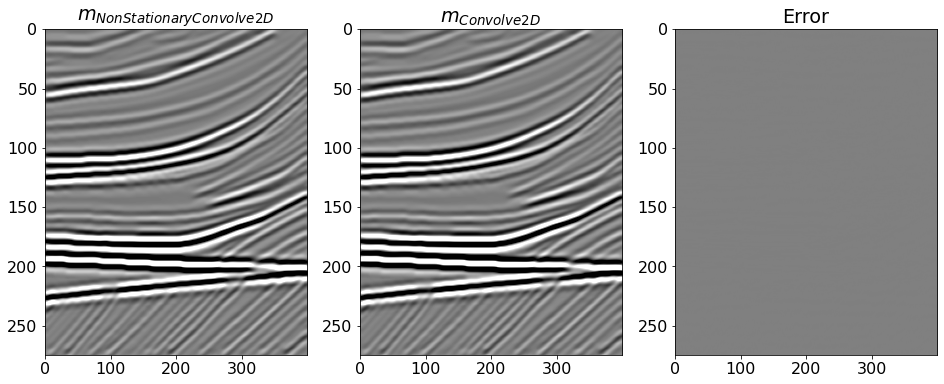

In [40]:
Cop = NonStationaryConvolve2D((nx, nz), psfs_stat, psfx, psfz, engine="numba")
Cop_stat = Convolve2D(dims=(nx, nz), h=psfs[4, 2], offset=(psfsize[0]//2, psfsize[1]//2))

mmigpsf = Cop * refl
mmigpsf_stat = Cop_stat * refl

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmigpsf.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[0].set_title(r'$m_{NonStationaryConvolve2D}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf_stat.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{Convolve2D}$')
axs[1].axis('tight')
axs[2].imshow(mmigpsf.T-mmigpsf_stat.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[2].set_title(r'Error')
axs[2].axis('tight');

np.allclose(mmigpsf, mmigpsf_stat)